In [37]:
!source $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh

import os
import tensorflow as tf
import matplotlib
import numpy as np
import cv2

In [38]:
rvl_cdip_images_dir = "/scratch/gpfs/RUSTOW/rvl_cdip_images/labels"

In [39]:
rvl_cdip_images_train_file_path = os.path.join(rvl_cdip_images_dir, "train.txt")
rvl_cdip_images_test_file_path = os.path.join(rvl_cdip_images_dir, "test.txt")
rvl_cdip_images_val_file_path = os.path.join(rvl_cdip_images_dir, "val.txt")

In [40]:
with open(rvl_cdip_images_train_file_path, "r") as f:
    rvl_cdip_images_train_file_list = f.readlines()
    
with open(rvl_cdip_images_test_file_path, "r") as f:
    rvl_cdip_images_test_file_list = f.readlines()
    
with open(rvl_cdip_images_val_file_path, "r") as f:
    rvl_cdip_images_val_file_list = f.readlines()

In [41]:
root_dir = "/scratch/gpfs/RUSTOW/rvl_cdip_images/images"

In [42]:
rvl_cdip_images_train_file_list = [x.split(" ")[0].strip() for x in rvl_cdip_images_train_file_list]
rvl_cdip_images_test_file_list = [x.split(" ")[0].strip() for x in rvl_cdip_images_test_file_list]
rvl_cdip_images_val_file_list = [x.split(" ")[0].strip() for x in rvl_cdip_images_val_file_list]

In [43]:
rvl_cdip_images_train_file_list = [os.path.join(root_dir, x) for x in rvl_cdip_images_train_file_list]
rvl_cdip_images_test_file_list = [os.path.join(root_dir, x) for x in rvl_cdip_images_test_file_list]
rvl_cdip_images_val_file_list = [os.path.join(root_dir, x) for x in rvl_cdip_images_val_file_list]

In [50]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize or any other preprocessing you'd like
    image = image / 255.0
    return image

def random_rotation(image):
    def rotate_fn(image_np):
        # Convert to numpy if not already
        image_np = np.array(image_np)
        
        h, w, _ = image_np.shape
        center = (w / 2, h / 2)
        angle = np.random.uniform(-180.0, 180.0)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image_np = cv2.warpAffine(image_np, M, (w, h))
        return rotated_image_np, angle

    rotated_image, angle = tf.py_function(rotate_fn, [image], [tf.float32, tf.float32])
    rotated_image.set_shape(image.shape)
    return rotated_image, angle

In [51]:
batch_size = 32

In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices(rvl_cdip_images_train_file_list)
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(random_rotation, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [53]:
test_dataset = tf.data.Dataset.from_tensor_slices(rvl_cdip_images_test_file_list)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(random_rotation, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [54]:
val_dataset = tf.data.Dataset.from_tensor_slices(rvl_cdip_images_val_file_list)
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(random_rotation, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size) 
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

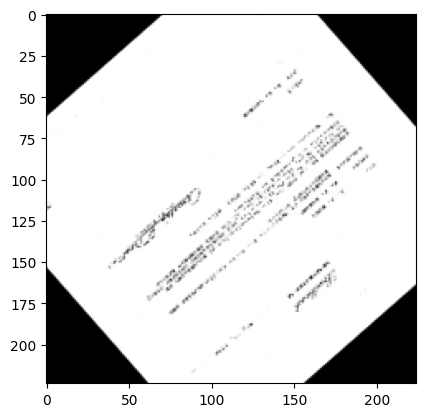

In [55]:
# show some of the images
import matplotlib.pyplot as plt
for image, y in train_dataset.take(1):
    plt.imshow(image[0])
    plt.show()

In [56]:
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="linear")
])

In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
  998/10000 [=>............................] - ETA: 33:23 - loss: 2649.1699 - mae: 35.7588